# Policy-based and actor-critic RL: DDPG, TD3, SAC, PPO
## Summary
    - DDPG learns a deterministic policy in continuous action spaces
    - Twin-delayed DDPG adds double learning, delayed parameter updates and external noise to output and target actions
    - SAC adds entropy for exploration, making it “soft”
    - PPO clips the ratio between new and old policies to prevent large policy updates

In [124]:
!nvidia-smi

Sat Jul 29 11:50:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.41       Driver Version: 527.41       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:58:00.0 Off |                  N/A |
| N/A   76C    P0    N/A /  N/A |    586MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [125]:
import warnings ; warnings.filterwarnings('ignore')
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['OMP_NUM_THREADS'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
# import threading
from torch.distributions import Normal

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

# import pybullet_envs
# import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
import gym
import io
import os
import gc

from gym import wrappers
from skimage.transform import resize
from skimage.color import rgb2gray
from subprocess import check_output
from IPython.display import display, HTML

LEAVE_PRINT_EVERY_N_SECS = 100
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('..', 'results')
# SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [126]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [127]:
torch.cuda.is_available()

True

In [128]:
def get_make_env_fn(**kargs):
    def make_env_fn(env_name: str = "donkey-generated-track-v0", seed=None, render=None, record=False,
                    unwrapped=False, monitor_mode=None, 
                    inner_wrappers=None, outer_wrappers=None):
        mdir = tempfile.mkdtemp()
        env = None
        if render:
            try:
                train_conf = {
                    "exe_path": "C:/Users/Phili/Desktop/RL_Project/DonkeySimWin/donkey_sim.x86_64",
                    "host": "127.0.0.1",
                    "port": 9091,
                    "car_name": "training",
                    "max_cte": 4.0,
                }
                env = gym.make(env_name, conf=train_conf)
                # env = gym.make(env_name, render=render)
            except:
                pass
        if env is None:
            train_conf = {
                    "exe_path": "C:/Users/Phili/Desktop/RL_Project/DonkeySimWin/donkey_sim.x86_64",
                    "host": "127.0.0.1",
                    "port": 9091,
                    "car_name": "training",
                    "max_cte": 4.0,
                    "render": False
                }
            env = gym.make(env_name, conf=train_conf)
        if seed is not None: env.seed(seed)
        env = env.unwrapped if unwrapped else env
        if inner_wrappers:
            for wrapper in inner_wrappers:
                env = wrapper(env)
        env = wrappers.Monitor(
            env, mdir, force=True, 
            mode=monitor_mode, 
            video_callable=lambda e_idx: record) if monitor_mode else env
        if outer_wrappers:
            for wrapper in outer_wrappers:
                env = wrapper(env)
        return env
    return make_env_fn, kargs

In [129]:
def get_videos_html(env_videos, title, max_n_videos=4):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [130]:
def get_gif_html(env_videos, title, subtitle_eps=None, max_n_videos=4):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '7',
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm',
                 '-crf', '20',
                 '-vf', 'scale=512:-1',
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert',
                 '-coalesce',
                 '-delay', '7',
                 '-loop', '0',
                 '-fuzz', '2%',
                 '+dither',
                 '-deconstruct',
                 '-layers', 'Optimize',
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        prefix = 'Trial ' if subtitle_eps is None else 'Episode '
        sufix = str(meta['episode_id'] if subtitle_eps is None \
                    else subtitle_eps[meta['episode_id']])
        strm += html_tag.format(prefix + sufix, encoded.decode('ascii'))
    return strm

In [131]:
class RenderUint8(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
    def render(self, mode='rgb_array'):
        frame = self.env.render(mode=mode)
        return frame.astype(np.uint8)

# SAC
<img src="../blob/img/08_sac.png" alt= “” width="600" height="300">

## FCQSA old

In [132]:
# class FCQSA(nn.Module):
#     def __init__(self,
#                  input_dim, 
#                  output_dim, 
#                  hidden_dims=(32,32), 
#                  activation_fc=F.relu):
#         super(FCQSA, self).__init__()
#         self.activation_fc = activation_fc

#         self.input_layer = nn.Linear(input_dim + output_dim, hidden_dims[0])
#         self.hidden_layers = nn.ModuleList()
#         for i in range(len(hidden_dims)-1):
#             hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
#             self.hidden_layers.append(hidden_layer)
#         self.output_layer = nn.Linear(hidden_dims[-1], 1)

#         device = "cpu"
#         if torch.cuda.is_available():
#             device = "cuda:0"
#         self.device = torch.device(device)
#         self.to(self.device)

#     def _format(self, state, action):
#         x, u = state, action
#         if not isinstance(x, torch.Tensor):
#             x = torch.tensor(x, 
#                              device=self.device, 
#                              dtype=torch.float32)
#             x = x.unsqueeze(0)
#         if not isinstance(u, torch.Tensor):
#             u = torch.tensor(u, 
#                              device=self.device, 
#                              dtype=torch.float32)
#             u = u.unsqueeze(0)
#         return x, u

#     def forward(self, state, action):
#         x, u = self._format(state, action)
#         test1 = torch.cat((x, u), dim=0)
#         print(test1.shape)
#         input = self.input_layer(test1)
#         # test2 = torch.cat((x, u), dim=0)
#         x = self.activation_fc(input)
#         for i, hidden_layer in enumerate(self.hidden_layers):
#             x = self.activation_fc(hidden_layer(x))
#         x = self.output_layer(x)
#         return x
    
#     def load(self, experiences):
#         states, actions, new_states, rewards, is_terminals = experiences
#         states = torch.from_numpy(states).float().to(self.device)
#         actions = torch.from_numpy(actions).float().to(self.device)
#         new_states = torch.from_numpy(new_states).float().to(self.device)
#         rewards = torch.from_numpy(rewards).float().to(self.device)
#         is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
#         return states, actions, new_states, rewards, is_terminals

## FCGP old

In [133]:
# class FCGP(nn.Module):
#     def __init__(self, 
#                  input_dim, 
#                  action_bounds,
#                  log_std_min=-20, 
#                  log_std_max=2,
#                  hidden_dims=(32,32), 
#                  activation_fc=F.relu,
#                  entropy_lr=0.001):
#         super(FCGP, self).__init__()
#         self.activation_fc = activation_fc
#         self.env_min, self.env_max = action_bounds
        
#         self.log_std_min = log_std_min
#         self.log_std_max = log_std_max
        
#         self.input_layer = nn.Linear(input_dim, 
#                                      hidden_dims[0])
        
#         self.hidden_layers = nn.ModuleList()
#         for i in range(len(hidden_dims)-1):
#             hidden_layer = nn.Linear(
#                 hidden_dims[i], hidden_dims[i+1])
#             self.hidden_layers.append(hidden_layer)

#         self.output_layer_mean = nn.Linear(hidden_dims[-1], len(self.env_max))
#         self.output_layer_log_std = nn.Linear(hidden_dims[-1], len(self.env_max))

#         device = "cpu"
#         if torch.cuda.is_available():
#             device = "cuda:0"
#         self.device = torch.device(device)
#         self.to(self.device)

#         self.env_min = torch.tensor(self.env_min,
#                                     device=self.device, 
#                                     dtype=torch.float32)

#         self.env_max = torch.tensor(self.env_max,
#                                     device=self.device, 
#                                     dtype=torch.float32)
        
#         self.nn_min = F.tanh(torch.Tensor([float('-inf')])).to(self.device)
#         self.nn_max = F.tanh(torch.Tensor([float('inf')])).to(self.device)
#         self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / \
#                                     (self.nn_max - self.nn_min) + self.env_min

#         self.target_entropy = -np.prod(self.env_max.shape)
#         self.logalpha = torch.zeros(1, requires_grad=True, device=self.device)
#         self.alpha_optimizer = optim.Adam([self.logalpha], lr=entropy_lr)

#     def _format(self, state):
#         x = state
#         if not isinstance(x, torch.Tensor):
#             x = torch.tensor(x, 
#                              device=self.device, 
#                              dtype=torch.float32)
#             x = x.unsqueeze(0)
#         return x

#     def forward(self, state):
#         x = self._format(state)
#         x = self.activation_fc(self.input_layer(x))
#         for hidden_layer in self.hidden_layers:
#             x = self.activation_fc(hidden_layer(x))
#         x_mean = self.output_layer_mean(x)
#         x_log_std = self.output_layer_log_std(x)
#         x_log_std = torch.clamp(x_log_std, 
#                                 self.log_std_min, 
#                                 self.log_std_max)
#         return x_mean, x_log_std

#     def full_pass(self, state, epsilon=1e-6):
#         mean, log_std = self.forward(state)

#         pi_s = Normal(mean, log_std.exp())
#         pre_tanh_action = pi_s.rsample()
#         tanh_action = torch.tanh(pre_tanh_action)
#         action = self.rescale_fn(tanh_action)

#         log_prob = pi_s.log_prob(pre_tanh_action) - torch.log(
#             (1 - tanh_action.pow(2)).clamp(0, 1) + epsilon)
#         log_prob = log_prob.sum(dim=1, keepdim=True)

#         return action, log_prob, self.rescale_fn(torch.tanh(mean))

#     def _update_exploration_ratio(self, greedy_action, action_taken):
#         env_min, env_max = self.env_min.cpu().numpy(), self.env_max.cpu().numpy()
#         self.exploration_ratio = np.mean(abs((greedy_action - action_taken)/(env_max - env_min)))

#     def _get_actions(self, state):
#         mean, log_std = self.forward(state)

#         action = self.rescale_fn(torch.tanh(Normal(mean, log_std.exp()).sample()))
#         greedy_action = self.rescale_fn(torch.tanh(mean))
#         random_action = np.random.uniform(low=self.env_min.cpu().numpy(),
#                                           high=self.env_max.cpu().numpy())

#         action_shape = self.env_max.cpu().numpy().shape
#         action = action.detach().cpu().numpy().reshape(action_shape)
#         greedy_action = greedy_action.detach().cpu().numpy().reshape(action_shape)
#         random_action = random_action.reshape(action_shape)

#         return action, greedy_action, random_action

#     def select_random_action(self, state):
#         action, greedy_action, random_action = self._get_actions(state)
#         self._update_exploration_ratio(greedy_action, random_action)
#         return random_action

#     def select_greedy_action(self, state):
#         action, greedy_action, random_action = self._get_actions(state)
#         self._update_exploration_ratio(greedy_action, greedy_action)
#         return greedy_action

#     def select_action(self, state):
#         action, greedy_action, random_action = self._get_actions(state)
#         self._update_exploration_ratio(greedy_action, action)
#         return action

## SAC old

In [134]:
# class SAC():
#     def __init__(self, 
#                  replay_buffer_fn,
#                  policy_model_fn, 
#                  policy_max_grad_norm, 
#                  policy_optimizer_fn, 
#                  policy_optimizer_lr,
#                  value_model_fn,
#                  value_max_grad_norm, 
#                  value_optimizer_fn, 
#                  value_optimizer_lr,
#                  n_warmup_batches,
#                  update_target_every_steps,
#                  tau,
#                  # new added 
#                  bounds,
#                  nA,
#                  nS
#                  ):
#         self.replay_buffer_fn = replay_buffer_fn

#         self.policy_model_fn = policy_model_fn
#         self.policy_max_grad_norm = policy_max_grad_norm
#         self.policy_optimizer_fn = policy_optimizer_fn
#         self.policy_optimizer_lr = policy_optimizer_lr

#         self.value_model_fn = value_model_fn
#         self.value_max_grad_norm = value_max_grad_norm
#         self.value_optimizer_fn = value_optimizer_fn
#         self.value_optimizer_lr = value_optimizer_lr

#         self.n_warmup_batches = n_warmup_batches
#         self.update_target_every_steps = update_target_every_steps

#         self.tau = tau

#         # new added
#         self.bounds = bounds
#         self.nA = nA
#         self.nS = nS

#     def optimize_model(self, experiences):
#         states, actions, rewards, next_states, is_terminals = experiences
#         batch_size = len(is_terminals)

#         # policy loss
#         current_actions, logpi_s, _ = self.policy_model.full_pass(states)

#         target_alpha = (logpi_s + self.policy_model.target_entropy).detach()
#         alpha_loss = -(self.policy_model.logalpha * target_alpha).mean()

#         self.policy_model.alpha_optimizer.zero_grad()
#         alpha_loss.backward()
#         self.policy_model.alpha_optimizer.step()
#         alpha = self.policy_model.logalpha.exp()

#         current_q_sa_a = self.online_value_model_a(states, current_actions)
#         current_q_sa_b = self.online_value_model_b(states, current_actions)
#         current_q_sa = torch.min(current_q_sa_a, current_q_sa_b)
#         policy_loss = (alpha * logpi_s - current_q_sa).mean()

#         # Q loss
#         ap, logpi_sp, _ = self.policy_model.full_pass(next_states)
#         q_spap_a = self.target_value_model_a(next_states, ap)
#         q_spap_b = self.target_value_model_b(next_states, ap)
#         q_spap = torch.min(q_spap_a, q_spap_b) - alpha * logpi_sp
#         target_q_sa = (rewards + self.gamma * q_spap * (1 - is_terminals)).detach()

#         q_sa_a = self.online_value_model_a(states, actions)
#         q_sa_b = self.online_value_model_b(states, actions)
#         qa_loss = (q_sa_a - target_q_sa).pow(2).mul(0.5).mean()
#         qb_loss = (q_sa_b - target_q_sa).pow(2).mul(0.5).mean()

#         self.value_optimizer_a.zero_grad()
#         qa_loss.backward()
#         torch.nn.utils.clip_grad_norm_(self.online_value_model_a.parameters(), 
#                                        self.value_max_grad_norm)
#         self.value_optimizer_a.step()

#         self.value_optimizer_b.zero_grad()
#         qb_loss.backward()
#         torch.nn.utils.clip_grad_norm_(self.online_value_model_b.parameters(),
#                                        self.value_max_grad_norm)
#         self.value_optimizer_b.step()

#         self.policy_optimizer.zero_grad()
#         policy_loss.backward()
#         torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), 
#                                        self.policy_max_grad_norm)        
#         self.policy_optimizer.step()

#     def interaction_step(self, state, env):
#         min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
#         if len(self.replay_buffer) < min_samples:
#             action = self.policy_model.select_random_action(state)
#         else:
#             action = self.policy_model.select_action(state)

#         new_state, reward, is_terminal, info = env.step(action)
#         new_state = encode_from_image(new_state, info)


#         is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
#         is_failure = is_terminal and not is_truncated
#         experience = (state, action, reward, new_state, float(is_failure))

#         self.replay_buffer.store(experience)
#         self.episode_reward[-1] += reward
#         self.episode_timestep[-1] += 1
#         self.episode_exploration[-1] += self.policy_model.exploration_ratio
#         return new_state, is_terminal

#     def update_value_networks(self, tau=None):
#         tau = self.tau if tau is None else tau
#         for target, online in zip(self.target_value_model_a.parameters(), 
#                                   self.online_value_model_a.parameters()):
#             target_ratio = (1.0 - tau) * target.data
#             online_ratio = tau * online.data
#             mixed_weights = target_ratio + online_ratio
#             target.data.copy_(mixed_weights)

#         for target, online in zip(self.target_value_model_b.parameters(), 
#                                   self.online_value_model_b.parameters()):
#             target_ratio = (1.0 - tau) * target.data
#             online_ratio = tau * online.data
#             mixed_weights = target_ratio + online_ratio
#             target.data.copy_(mixed_weights)

#     def train(self, make_env_fn, make_env_kargs, seed, gamma, 
#               max_minutes, max_episodes, goal_mean_100_reward):
#         training_start, last_debug_time = time.time(), float('-inf')

#         self.checkpoint_dir = tempfile.mkdtemp()
#         self.make_env_fn = make_env_fn
#         self.make_env_kargs = make_env_kargs
#         self.seed = seed
#         self.gamma = gamma
        
#         env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
#         torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
#         # nS, nA = env.observation_space.shape[0], env.action_space.shape[0]
#         # action_bounds = env.action_space.low, env.action_space.high
#         nS = self.nS
#         nA = self.nA
#         action_bounds = self.bounds

#         self.episode_timestep = []
#         self.episode_reward = []
#         self.episode_seconds = []
#         self.evaluation_scores = []        
#         self.episode_exploration = []

#         self.target_value_model_a = self.value_model_fn(nS, nA)
#         self.online_value_model_a = self.value_model_fn(nS, nA)
#         self.target_value_model_b = self.value_model_fn(nS, nA)
#         self.online_value_model_b = self.value_model_fn(nS, nA)
#         self.update_value_networks(tau=1.0)

#         self.policy_model = self.policy_model_fn(nS, action_bounds)

#         self.value_optimizer_a = self.value_optimizer_fn(self.online_value_model_a,
#                                                          self.value_optimizer_lr)
#         self.value_optimizer_b = self.value_optimizer_fn(self.online_value_model_b,
#                                                          self.value_optimizer_lr)
#         self.policy_optimizer = self.policy_optimizer_fn(self.policy_model,
#                                                          self.policy_optimizer_lr)

#         self.replay_buffer = self.replay_buffer_fn()
                    
#         result = np.empty((max_episodes, 5))
#         result[:] = np.nan
#         training_time = 0
#         for episode in range(1, max_episodes + 1):
#             episode_start = time.time()
            
#             state, is_terminal = env.reset(), False
#             self.episode_reward.append(0.0)
#             self.episode_timestep.append(0.0)
#             self.episode_exploration.append(0.0)

#             for step in count():
#                 state, is_terminal = self.interaction_step(state, env)

#                 min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
#                 if len(self.replay_buffer) > min_samples:
#                     experiences = self.replay_buffer.sample()
#                     experiences = self.online_value_model_a.load(experiences)
#                     self.optimize_model(experiences)

#                 if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
#                     self.update_value_networks()

#                 if is_terminal:
#                     gc.collect()
#                     break

#             # stats
#             episode_elapsed = time.time() - episode_start
#             self.episode_seconds.append(episode_elapsed)
#             training_time += episode_elapsed
#             evaluation_score, _ = self.evaluate(self.policy_model, env)
#             self.save_checkpoint(episode-1, self.policy_model)

#             total_step = int(np.sum(self.episode_timestep))
#             self.evaluation_scores.append(evaluation_score)
            
#             mean_10_reward = np.mean(self.episode_reward[-10:])
#             std_10_reward = np.std(self.episode_reward[-10:])
#             mean_100_reward = np.mean(self.episode_reward[-100:])
#             std_100_reward = np.std(self.episode_reward[-100:])
#             mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
#             std_100_eval_score = np.std(self.evaluation_scores[-100:])
#             lst_100_exp_rat = np.array(
#                 self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
#             mean_100_exp_rat = np.mean(lst_100_exp_rat)
#             std_100_exp_rat = np.std(lst_100_exp_rat)
            
#             wallclock_elapsed = time.time() - training_start
#             result[episode-1] = total_step, mean_100_reward, \
#                 mean_100_eval_score, training_time, wallclock_elapsed
            
#             reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
#             reached_max_minutes = wallclock_elapsed >= max_minutes * 60
#             reached_max_episodes = episode >= max_episodes
#             reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
#             training_is_over = reached_max_minutes or \
#                                reached_max_episodes or \
#                                reached_goal_mean_reward
#             elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
#             debug_message = 'el {}, ep {:04}, ts {:07}, '
#             debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
#             debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
#             debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
#             debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
#             debug_message = debug_message.format(
#                 elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
#                 mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
#                 mean_100_eval_score, std_100_eval_score)
#             print(debug_message, end='\r', flush=True)
#             if reached_debug_time or training_is_over:
#                 print(ERASE_LINE + debug_message, flush=True)
#                 last_debug_time = time.time()
#             if training_is_over:
#                 if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
#                 if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
#                 if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
#                 break
                
#         final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=100)
#         wallclock_time = time.time() - training_start
#         print('Training complete.')
#         print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
#               ' {:.2f}s wall-clock time.\n'.format(
#                   final_eval_score, score_std, training_time, wallclock_time))
#         env.close() ; del env
#         self.get_cleaned_checkpoints()
#         return result, final_eval_score, training_time, wallclock_time
    
#     def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
#         rs = []
#         for _ in range(n_episodes):
#             s, d = eval_env.reset(), False
#             rs.append(0)
#             for _ in count():
#                 a = eval_policy_model.select_greedy_action(s)
#                 s, r, d, _ = eval_env.step(a)
#                 rs[-1] += r
#                 if d: break
#         return np.mean(rs), np.std(rs)

#     def get_cleaned_checkpoints(self, n_checkpoints=4):
#         try: 
#             return self.checkpoint_paths
#         except AttributeError:
#             self.checkpoint_paths = {}

#         paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
#         paths_dic = {int(path.split('.')[-2]):path for path in paths}
#         last_ep = max(paths_dic.keys())
#         # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
#         checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1

#         for idx, path in paths_dic.items():
#             if idx in checkpoint_idxs:
#                 self.checkpoint_paths[idx] = path
#             else:
#                 os.unlink(path)

#         return self.checkpoint_paths

#     def demo_last(self, title='Fully-trained {} Agent', n_episodes=2, max_n_videos=2):
#         env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

#         checkpoint_paths = self.get_cleaned_checkpoints()
#         last_ep = max(checkpoint_paths.keys())
#         self.policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

#         self.evaluate(self.policy_model, env, n_episodes=n_episodes)
#         env.close()
#         data = get_gif_html(env_videos=env.videos, 
#                             title=title.format(self.__class__.__name__),
#                             max_n_videos=max_n_videos)
#         del env
#         return HTML(data=data)

#     def demo_progression(self, title='{} Agent progression', max_n_videos=4):
#         env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

#         checkpoint_paths = self.get_cleaned_checkpoints()
#         for i in sorted(checkpoint_paths.keys()):
#             self.policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
#             self.evaluate(self.policy_model, env, n_episodes=1)

#         env.close()
#         data = get_gif_html(env_videos=env.videos, 
#                             title=title.format(self.__class__.__name__),
#                             subtitle_eps=sorted(checkpoint_paths.keys()),
#                             max_n_videos=max_n_videos)
#         del env
#         return HTML(data=data)

#     def save_checkpoint(self, episode_idx, model):
#         torch.save(model.state_dict(), 
#                    os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

## FCQSA

In [135]:
class FCQSA(nn.Module):
    # def __init__(self,
    #              input_dim, 
    #              output_dim, 
    #              hidden_dims=(32,32), 
    #              activation_fc=F.relu):
    #     super(FCQSA, self).__init__()
    #     self.activation_fc = activation_fc

    #     self.input_layer = nn.Linear(input_dim + output_dim, hidden_dims[0])
    #     self.hidden_layers = nn.ModuleList()
    #     for i in range(len(hidden_dims)-1):
    #         hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
    #         self.hidden_layers.append(hidden_layer)
    #     self.output_layer = nn.Linear(hidden_dims[-1], 1)

    #     device = "cpu"
    #     if torch.cuda.is_available():
    #         device = "cuda:0"
    #     self.device = torch.device(device)
    #     self.to(self.device)
    def __init__(self, input_dim, output_dim, obs_space_size=32, hidden_dims=(32, 32), activation_fc=F.relu):
        super(FCQSA, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim + output_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state, action):
        x, u = state, action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u, 
                             device=self.device, 
                             dtype=torch.float32)
            u = u.unsqueeze(0)
        return x, u

    # def forward(self, state, action):
    #     x, u = self._format(state, action)
    #     x = self.activation_fc(self.input_layer(torch.cat((x, u), dim=1)))
    #     for i, hidden_layer in enumerate(self.hidden_layers):
    #         x = self.activation_fc(hidden_layer(x))
    #     x = self.output_layer(x)
    #     return x
    
    #     def forward(self, state, action):
#         x, u = self._format(state, action)
#         test1 = torch.cat((x, u), dim=0)
#         print(test1.shape)
#         input = self.input_layer(test1)
#         # test2 = torch.cat((x, u), dim=0)
#         x = self.activation_fc(input)
#         for i, hidden_layer in enumerate(self.hidden_layers):
#             x = self.activation_fc(hidden_layer(x))
#         x = self.output_layer(x)
#         return x

    def forward(self, state, action):
        x, u = self._format(state, action)
        x = self.activation_fc(self.input_layer(torch.cat((x, u), dim=1)))
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
        
    # def load(self, experiences):
    #     states, actions, new_states, rewards, is_terminals = experiences
    #     states = torch.from_numpy(states).float().to(self.device)
    #     actions = torch.from_numpy(actions).float().to(self.device)
    #     new_states = torch.from_numpy(new_states).float().to(self.device)
    #     rewards = torch.from_numpy(rewards).float().to(self.device)
    #     is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
    #     return states, actions, new_states, rewards, is_terminals
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

## FCGP

In [170]:
class FCGP(nn.Module):
    def __init__(self, 
                 input_dim, 
                 action_bounds,
                 log_std_min=-20, 
                 log_std_max=2,
                 hidden_dims=(32,32), 
                 activation_fc=F.relu,
                 entropy_lr=0.001):
        super(FCGP, self).__init__()
        self.activation_fc = activation_fc
        self.env_min, self.env_max = action_bounds
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        self.output_layer_mean = nn.Linear(hidden_dims[-1], len(self.env_max))
        self.output_layer_log_std = nn.Linear(hidden_dims[-1], len(self.env_max))
        # self.output_layer_mean = nn.Linear(hidden_dims[-1], 4)
        # self.output_layer_log_std = nn.Linear(hidden_dims[-1], 4)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

        self.env_min = torch.tensor(self.env_min,
                                    device=self.device, 
                                    dtype=torch.float32)

        self.env_max = torch.tensor(self.env_max,
                                    device=self.device, 
                                    dtype=torch.float32)
        
        self.nn_min = F.tanh(torch.Tensor([float('-inf')])).to(self.device)
        self.nn_max = F.tanh(torch.Tensor([float('inf')])).to(self.device)
        self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / \
                                    (self.nn_max - self.nn_min) + self.env_min

        self.target_entropy = -np.prod(self.env_max.shape)
        self.logalpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.logalpha], lr=entropy_lr)
    # def __init__(self, 
    #              input_dim, 
    #              action_bounds,
    #              log_std_min=-20, 
    #              log_std_max=2,
    #              hidden_dims=(32,32),  # Change the input layer to have 32 neurons
    #              activation_fc=F.relu,
    #              entropy_lr=0.001):
    #     super(FCGP, self).__init__()
    #     self.activation_fc = activation_fc
    #     self.env_min, self.env_max = action_bounds
        
    #     self.log_std_min = log_std_min
    #     self.log_std_max = log_std_max
        
    #     self.input_layer = nn.Linear(input_dim, hidden_dims[0]) 

    #     self.hidden_layers = nn.ModuleList()
    #     for i in range(len(hidden_dims) - 1):
    #         hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
    #         self.hidden_layers.append(hidden_layer)

    #     self.output_layer_mean = nn.Linear(hidden_dims[-1], len(self.env_max))
    #     self.output_layer_log_std = nn.Linear(hidden_dims[-1], len(self.env_max))

    #     device = "cpu"
    #     if torch.cuda.is_available():
    #         device = "cuda:0"
    #     self.device = torch.device(device)
    #     self.to(self.device)

    #     self.env_min = torch.tensor(self.env_min, device=self.device, dtype=torch.float32)
    #     self.env_max = torch.tensor(self.env_max, device=self.device, dtype=torch.float32)

    #     self.nn_min = F.tanh(torch.Tensor([float('-inf')])).to(self.device)
    #     self.nn_max = F.tanh(torch.Tensor([float('inf')])).to(self.device)
    #     self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / \
    #                                 (self.nn_max - self.nn_min) + self.env_min

    #     self.target_entropy = -np.prod(self.env_max.shape)
    #     self.logalpha = torch.zeros(1, requires_grad=True, device=self.device)
    #     self.alpha_optimizer = optim.Adam([self.logalpha], lr=entropy_lr)

    # def __init__(self, 
    #              input_dim, 
    #              action_bounds,
    #              log_std_min=-20, 
    #              log_std_max=2,
    #              hidden_dims=(32,32),  # Change the input layer to have 32 neurons
    #              activation_fc=F.relu,
    #              entropy_lr=0.001):
    #     super(FCGP, self).__init__()
    #     self.activation_fc = activation_fc
    #     self.env_min, self.env_max = action_bounds
    #     self.input_layer = nn.Linear(input_dim, hidden_dims[0])

    #     self.hidden_layers = nn.ModuleList()
    #     for i in range(len(hidden_dims) - 1):
    #         hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
    #         self.hidden_layers.append(hidden_layer)
    #     self.output_layer = nn.Linear(hidden_dims[-1], len(action_bounds))

    #     self.env_min, self.env_max = zip(*action_bounds)
    #     self.output_layer_mean = nn.Linear(hidden_dims[-1], len(self.env_max))
    #     self.output_layer_log_std = nn.Linear(hidden_dims[-1], len(self.env_max))

    #     device = "cpu"
    #     if torch.cuda.is_available():
    #         device = "cuda:0"
    #     self.device = torch.device(device)
    #     self.to(self.device)

    #     self.env_min = torch.tensor(self.env_min, device=self.device, dtype=torch.float32)
    #     self.env_max = torch.tensor(self.env_max, device=self.device, dtype=torch.float32)

    #     self.nn_min = F.tanh(torch.Tensor([float('-inf')])).to(self.device)
    #     self.nn_max = F.tanh(torch.Tensor([float('inf')])).to(self.device)
    #     self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / \
    #                                 (self.nn_max - self.nn_min) + self.env_min

    #     self.target_entropy = -np.prod(self.env_max.shape)
    #     self.logalpha = torch.zeros(1, requires_grad=True, device=self.device)
    #     self.alpha_optimizer = optim.Adam([self.logalpha], lr=entropy_lr)



    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32)
        return x.view(-1, 32)

    # def forward(self, state):
    #     x = self._format(state)
    #     x = self.activation_fc(self.input_layer(x))
    #     for hidden_layer in self.hidden_layers:
    #         x = self.activation_fc(hidden_layer(x))
    #     output = self.output_layer(x)
    #     return output

    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x_mean = self.output_layer_mean(x)
        x_log_std = self.output_layer_log_std(x)
        x_log_std = torch.clamp(x_log_std, 
                                self.log_std_min, 
                                self.log_std_max)
        return x_mean, x_log_std
    
    

    # def _format(self, state):
    #     x = state
    #     if not isinstance(x, torch.Tensor):
    #         x = torch.tensor(x, 
    #                          device=self.device, 
    #                          dtype=torch.float32)
    #         x = x.unsqueeze(0)
    #     return x

    # # def forward(self, state):
    # #     x = self._format(state)
    # #     x = self.activation_fc(self.input_layer(x))
    # #     for hidden_layer in self.hidden_layers:
    # #         x = self.activation_fc(hidden_layer(x))
    # #     x_mean = self.output_layer_mean(x)
    # #     x_log_std = self.output_layer_log_std(x)
    # #     x_log_std = torch.clamp(x_log_std, 
    # #                             self.log_std_min, 
    # #                             self.log_std_max)
    # #     return x_mean, x_log_std

    # def forward(self, state):
    #     x = self._format(state)
    #     x = self.activation_fc(self.input_layer(x))
    #     for hidden_layer in self.hidden_layers:
    #         x = self.activation_fc(hidden_layer(x))
    #     x_mean = self.output_layer_mean(x)
    #     x_log_std = self.output_layer_log_std(x)
    #     x_log_std = torch.clamp(x_log_std, self.log_std_min, self.log_std_max)
    #     return x_mean, x_log_std

    def full_pass(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)

        pi_s = Normal(mean, log_std.exp())
        pre_tanh_action = pi_s.rsample()
        tanh_action = torch.tanh(pre_tanh_action)
        action = self.rescale_fn(tanh_action)

        log_prob = pi_s.log_prob(pre_tanh_action) - torch.log(
            (1 - tanh_action.pow(2)).clamp(0, 1) + epsilon)
        log_prob = log_prob.sum(dim=1, keepdim=True)

        return action, log_prob, self.rescale_fn(torch.tanh(mean))

    def _update_exploration_ratio(self, greedy_action, action_taken):
        env_min, env_max = self.env_min.cpu().numpy(), self.env_max.cpu().numpy()
        self.exploration_ratio = np.mean(abs((greedy_action - action_taken)/(env_max - env_min)))

    def _get_actions(self, state):
        if len(state) != 32 and state.shape != (1, 32):
            # print(state.shape)
            state = encode_from_image(state, 0.0)
        mean, log_std = self.forward(state)

        action = self.rescale_fn(torch.tanh(Normal(mean, log_std.exp()).sample()))
        greedy_action = self.rescale_fn(torch.tanh(mean))
        random_action = np.random.uniform(low=self.env_min.cpu().numpy(),
                                          high=self.env_max.cpu().numpy(),
                                          size=(2,))  # added
        
        # action_shape = (mean.shape[0], 2)  # Set the correct shape (batch_size, 2)
        action_shape = self.env_max.cpu().numpy().shape
        action = action.detach().cpu().numpy().reshape(action_shape)
        greedy_action = greedy_action.detach().cpu().numpy().reshape(action_shape)
        random_action = random_action.reshape(action_shape)

        return action, greedy_action, random_action

    def select_random_action(self, state):
        action, greedy_action, random_action = self._get_actions(state)
        self._update_exploration_ratio(greedy_action, random_action)
        return random_action

    def select_greedy_action(self, state):
        action, greedy_action, random_action = self._get_actions(state)
        self._update_exploration_ratio(greedy_action, greedy_action)
        return greedy_action

    # def select_action(self, state):
    #     with torch.no_grad():
    #         action = self.forward(state)
    #         action = torch.clamp(action, min=-1.0, max=1.0)
    #         action = action * torch.tensor(self.env_max) + torch.tensor(self.env_min)
    #     return action.cpu().numpy()

    def select_action(self, state):
        action, greedy_action, random_action = self._get_actions(state)
        self._update_exploration_ratio(greedy_action, action)
        return action

## SAC Model

In [226]:
class SAC():
    def __init__(self, 
                 replay_buffer_fn,
                 policy_model_fn, 
                 policy_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn,
                 value_max_grad_norm, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau
                #  ,
                #  bounds,
                #  nA,
                #  nS
                 ):
        self.replay_buffer_fn = replay_buffer_fn

    #     self.policy_model_fn = policy_model_fn
    #     self.policy_max_grad_norm = policy_max_grad_norm
    #     self.policy_optimizer_fn = policy_optimizer_fn
    #     self.policy_optimizer_lr = policy_optimizer_lr

    #     self.value_model_fn = value_model_fn
    #     self.value_max_grad_norm = value_max_grad_norm
    #     self.value_optimizer_fn = value_optimizer_fn
    #     self.value_optimizer_lr = value_optimizer_lr

    #     self.n_warmup_batches = n_warmup_batches
    #     self.update_target_every_steps = update_target_every_steps

    #     self.tau = tau
    #         self.replay_buffer_fn = replay_buffer_fn

        self.policy_model_fn = policy_model_fn
        self.policy_max_grad_norm = policy_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr

        self.value_model_fn = value_model_fn
        self.value_max_grad_norm = value_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr

        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps

        self.tau = tau

        # # new added
        # self.bounds = bounds
        # self.nA = nA
        # self.nS = nS


    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)

        # Enable anomaly detection for debugging
        torch.autograd.set_detect_anomaly(True)

        # policy loss
        current_actions, logpi_s, _ = self.policy_model.full_pass(states)

        target_alpha = (logpi_s + self.policy_model.target_entropy).detach()
        alpha_loss = -(self.policy_model.logalpha * target_alpha).mean()

        self.policy_model.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.policy_model.alpha_optimizer.step()
        alpha = self.policy_model.logalpha.exp()

        current_q_sa_a = self.online_value_model_a(states, current_actions)
        current_q_sa_b = self.online_value_model_b(states, current_actions)
        current_q_sa = torch.min(current_q_sa_a, current_q_sa_b)
        policy_loss = (alpha * logpi_s.detach() - current_q_sa.detach()).mean()
        # policy_loss = (alpha * logpi_s.detach() - current_q_sa).mean()

        # Q loss
        ap, logpi_sp, _ = self.policy_model.full_pass(next_states)
        q_spap_a = self.target_value_model_a(next_states, ap)
        q_spap_b = self.target_value_model_b(next_states, ap)
        q_spap = torch.min(q_spap_a, q_spap_b) - alpha * logpi_sp
        target_q_sa = (rewards + self.gamma * q_spap * (1 - is_terminals)).detach()

        q_sa_a = self.online_value_model_a(states, actions)
        q_sa_b = self.online_value_model_b(states, actions)
        qa_loss = (q_sa_a - target_q_sa).pow(2).mul(0.5).mean()
        qb_loss = (q_sa_b - target_q_sa).pow(2).mul(0.5).mean()

        self.value_optimizer_a.zero_grad()
        qa_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model_a.parameters(), 
                                       self.value_max_grad_norm)
        self.value_optimizer_a.step()

        self.value_optimizer_b.zero_grad()
        qb_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model_b.parameters(),
                                       self.value_max_grad_norm)
        self.value_optimizer_b.step()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), 
                                       self.policy_max_grad_norm)        
        self.policy_optimizer.step()

    def interaction_step(self, state, env):
        if len(state) != 32 and state.shape != (1, 32):
            # print(state.shape)
            state = encode_from_image(state, 0.0)
        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
        if len(self.replay_buffer) < min_samples:
            action = self.policy_model.select_random_action(state)
        else:
            action = self.policy_model.select_action(state)

        new_state, reward, is_terminal, info = env.step(action)
        new_state = encode_from_image(new_state, info)

        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))

        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += self.policy_model.exploration_ratio
        return new_state, is_terminal

    def update_value_networks(self, tau=None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_value_model_a.parameters(), 
                                  self.online_value_model_a.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

        for target, online in zip(self.target_value_model_b.parameters(), 
                                  self.online_value_model_b.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = os.path.join(os.path.dirname("__file__"), "checkpoints")
        os.makedirs(self.checkpoint_dir, exist_ok=True)    # tempfile.mkdtemp()
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        # nS, nA = env.observation_space.shape[0], env.action_space.shape[0]
        nS, nA = 32, env.action_space.shape[0] # 4
        action_bounds = env.action_space.low, env.action_space.high
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []

        self.target_value_model_a = self.value_model_fn(nS, nA)
        self.online_value_model_a = self.value_model_fn(nS, nA)
        self.target_value_model_b = self.value_model_fn(nS, nA)
        self.online_value_model_b = self.value_model_fn(nS, nA)
        self.update_value_networks(tau=1.0)

        self.policy_model = self.policy_model_fn(nS, action_bounds)

        self.value_optimizer_a = self.value_optimizer_fn(self.online_value_model_a,
                                                         self.value_optimizer_lr)
        self.value_optimizer_b = self.value_optimizer_fn(self.online_value_model_b,
                                                         self.value_optimizer_lr)
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model,
                                                         self.policy_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)

                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_value_model_a.load(experiences)
                    self.optimize_model(experiences)

                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_value_networks()

                if is_terminal:
                    gc.collect()
                    break

            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.policy_model, env)
            self.save_checkpoint(episode-1, self.policy_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:07}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=10)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = eval_policy_model.select_greedy_action(s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=4):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int64)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths

    def demo_last(self, title='Fully-trained {} Agent', n_episodes=2, max_n_videos=2):
        # env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')

        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

        self.evaluate(self.policy_model, env, n_episodes=n_episodes)
        env.close()
        # data = get_gif_html(env_videos=env.videos, 
        #                     title=title.format(self.__class__.__name__),
        #                     max_n_videos=max_n_videos)
        del env
        # return HTML(data=data)
        return checkpoint_paths.keys()

    def demo_progression(self, title='{} Agent progression', max_n_videos=4):
        # env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')

        checkpoint_paths = self.get_cleaned_checkpoints()
        for i in sorted(checkpoint_paths.keys()):
            self.policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.policy_model, env, n_episodes=1)

        env.close()
        # data = get_gif_html(env_videos=env.videos, 
        #                     title=title.format(self.__class__.__name__),
        #                     subtitle_eps=sorted(checkpoint_paths.keys()),
        #                     max_n_videos=max_n_videos)
        del env
        return checkpoint_paths.keys()
        # return HTML(data=data)

    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

## Replay Buffer

In [227]:
class ReplayBuffer():
    def __init__(self, 
                 max_size=10000, 
                 batch_size=64):
        self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0
    
    def store(self, sample):
        s, a, r, p, d = sample
        self.ss_mem[self._idx] = s
        self.as_mem[self._idx] = a
        self.rs_mem[self._idx] = r
        self.ps_mem[self._idx] = p
        self.ds_mem[self._idx] = d
        
        self._idx += 1
        self._idx = self._idx % self.max_size

        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size

        idxs = np.random.choice(
            self.size, batch_size, replace=False)
        experiences = np.vstack(self.ss_mem[idxs]), \
                      np.vstack(self.as_mem[idxs]), \
                      np.vstack(self.rs_mem[idxs]), \
                      np.vstack(self.ps_mem[idxs]), \
                      np.vstack(self.ds_mem[idxs])
        return experiences

    def __len__(self):
        return self.size

In [228]:
import gym_donkeycar

In [229]:
PATH_TO_APP = r"C:\Users\Phili\Desktop\RL_Project\DonkeySimWin"
exe_path = f"{PATH_TO_APP}/donkey_sim.exe"
port = 9091

conf = { "exe_path" : exe_path, "port" : port }

# env = gym.make("donkey-generated-track-v0", conf=conf)

## Autoencoder


In [230]:
import sys
import os
sys.path.append(os.path.join(os.path.dirname("__file__"), "RL_gh/twitch/"))
import tensorflow as tf
from ae.autoencoder import load_ae
import cv2
import matplotlib.pyplot as plt

In [231]:
model_path = r"C:\Users\Phili\Desktop\RL_Project\RL_gh\ae-32_1689619355_best.pkl"
test_pictures_path = r"C:\Users\Phili\Desktop\RL_Project\RL_gh\twitch\logs\dataset-test\\"

In [232]:
ae_model = load_ae(model_path)

def encode_from_image(obs: np.array, infos):
    global ae_model
    encoded_image = ae_model.encode_from_raw_image(obs[:, :, ::-1])
    # speed = infos["speed"]
    # new_obs = np.concatenate([encoded_image.flatten(), [speed]])
    return encoded_image

Dim AE = 32
PyTorch 1.11.0


In [233]:

# ae_model = load_ae(model_path)
# all_images = os.listdir(test_pictures_path)
# sample_image_path = test_pictures_path + all_images[0]
# sample_image = cv2.imread(sample_image_path)[:,:,::-1]
# sample_image.shape
# plt.imshow(sample_image)

# encoded_image = ae_model.encode_from_raw_image(sample_image)
# encoded_image, encoded_image.shape
# decoded_image = ae_model.decode(encoded_image)
# decoded_image[0].shape
# plt.imshow(decoded_image[0][:,:,::-1])

In [234]:
SEEDS = [12]

## Training loop

In [236]:
sac_results = []
best_agent, best_eval_score = None, float('-inf')
# for seed in SEEDS:
# environment_settings = {
#     'env_name': "donkey-generated-track-v0",
#     'gamma': 0.99,
#     'max_minutes': 300,
#     'max_episodes': 10000,
#     'goal_mean_100_reward': 2000
# }

sac_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': "donkey-generated-track-v0",
        # 'gamma': 0.3,
        # 'max_minutes': 2,
        # 'max_episodes': 10,
        'gamma': 0.99,
        'max_minutes': 300,
        'max_episodes': 10000,
        'goal_mean_100_reward': 2000
    }

    policy_model_fn = lambda nS, bounds: FCGP(nS, bounds, hidden_dims=(32,32))
    policy_max_grad_norm = float('inf')
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0003

    value_model_fn = lambda nS, nA: FCQSA(nS, nA, hidden_dims=(32,32))
    value_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0005

    # replay_buffer_fn = lambda: ReplayBuffer(max_size=100000, batch_size=64)
    replay_buffer_fn = lambda: ReplayBuffer(max_size=100000, batch_size=64)

    n_warmup_batches = 10    # 10
    update_target_every_steps = 1
    tau = 0.001

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
                
    agent = SAC(replay_buffer_fn,
                policy_model_fn, 
                policy_max_grad_norm,
                policy_optimizer_fn, 
                policy_optimizer_lr,
                value_model_fn,
                value_max_grad_norm, 
                value_optimizer_fn, 
                value_optimizer_lr, 
                n_warmup_batches,
                update_target_every_steps,
                tau)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name, inner_wrappers=[RenderUint8])
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    sac_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
sac_results = np.array(sac_results)
_ = BEEP()
# nS = torch.ones(33)
# nA = torch.ones(4)
# bounds = ([-0.5, 0],[0.5, 1])

# # policy_model_fn = lambda nS, bounds: FCGP(nS, bounds, hidden_dims=(256,256))
# policy_model_fn = FCGP(nS, bounds, hidden_dims=(256,256))

# policy_max_grad_norm = float('inf')
# policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
# policy_optimizer_lr = 0.0003

# value_model_fn = FCQSA(nS, nA, hidden_dims=(256,256))
# # value_model_fn = lambda nS, nA: FCQSA(nS, nA, hidden_dims=(256,256))
# value_max_grad_norm = float('inf')
# value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
# value_optimizer_lr = 0.0005

# replay_buffer_fn = lambda: ReplayBuffer(max_size=100000, batch_size=64)
# n_warmup_batches = 10
# update_target_every_steps = 1
# tau = 0.001

# seed = 12

# env_name, gamma, max_minutes, \
# max_episodes, goal_mean_100_reward = environment_settings.values()
            
# agent = SAC(replay_buffer_fn,
#             policy_model_fn, 
#             policy_max_grad_norm,
#             policy_optimizer_fn, 
#             policy_optimizer_lr,
#             value_model_fn,
#             value_max_grad_norm, 
#             value_optimizer_fn, 
#             value_optimizer_lr, 
#             n_warmup_batches,
#             update_target_every_steps,
#             tau, 
#             bounds,
#             nA,
#             nS)

# make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name, inner_wrappers=[RenderUint8])
# result, final_eval_score, training_time, wallclock_time = agent.train(
#     make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
# sac_results.append(result)
# if final_eval_score > best_eval_score:
#     best_eval_score = final_eval_score
#     best_agent = agent
# sac_results = np.array(sac_results)
# _ = BEEP()

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
C:/Users/Phili/Desktop/RL_Project/DonkeySimWin/donkey_sim.x86_64 does not exist. you must start sim manually.


INFO:gym_donkeycar.core.client:connecting to 127.0.0.1:9091 


loading scene generated_track


INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!


el 00:00:10, ep 0000, ts 0000014, ar 10 010.8±000.0, 100 010.8±000.0, ex 100 0.3±0.0, ev 003.8±000.0


INFO:gym_donkeycar.envs.donkey_sim:New lap time: 4.44 seconds


INFO:gym_donkeycar.envs.donkey_sim:New lap time: 2.65 seconds
INFO:gym_donkeycar.envs.donkey_sim:New lap time: 2.9 seconds


INFO:gym_donkeycar.envs.donkey_sim:New lap time: 2.96 seconds


el 00:00:53, ep 0009, ts 0000033, ar 10 000.5±003.5, 100 000.5±003.5, ex 100 0.2±0.1, ev 000.9±001.1
--> reached_max_episodes ✕
Training complete.
Final evaluation score 0.54±0.50 in 29.60s training time, 70.52s wall-clock time.



In [ ]:
# best_agent = SAC(replay_buffer_fn,
#                 policy_model_fn, 
#                 policy_max_grad_norm,
#                 policy_optimizer_fn, 
#                 policy_optimizer_lr,
#                 value_model_fn,
#                 value_max_grad_norm, 
#                 value_optimizer_fn, 
#                 value_optimizer_lr, 
#                 n_warmup_batches,
#                 update_target_every_steps,
#                 tau)

In [ ]:
# make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name, inner_wrappers=[RenderUint8])
# result, final_eval_score, training_time, wallclock_time = agent.train(
#     make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
# sac_results.append(result)
# if final_eval_score > best_eval_score:
#     best_eval_score = final_eval_score
#     best_agent = agent
# sac_results = np.array(sac_results)
# _ = BEEP()

In [237]:
# mnaually restart env
best_agent.demo_progression()

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
C:/Users/Phili/Desktop/RL_Project/DonkeySimWin/donkey_sim.x86_64 does not exist. you must start sim manually.


INFO:gym_donkeycar.core.client:connecting to 127.0.0.1:9091 
INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!


dict_keys([0, 3, 6, 9])

In [238]:
best_agent.demo_last()

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
C:/Users/Phili/Desktop/RL_Project/DonkeySimWin/donkey_sim.x86_64 does not exist. you must start sim manually.


INFO:gym_donkeycar.core.client:connecting to 127.0.0.1:9091 
INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!


dict_keys([0, 3, 6, 9])

In [ ]:
sac_max_t, sac_max_r, sac_max_s, \
sac_max_sec, sac_max_rt = np.max(sac_results, axis=0).T
sac_min_t, sac_min_r, sac_min_s, \
sac_min_sec, sac_min_rt = np.min(sac_results, axis=0).T
sac_mean_t, sac_mean_r, sac_mean_s, \
sac_mean_sec, sac_mean_rt = np.mean(sac_results, axis=0).T
sac_x = np.arange(len(sac_mean_s))

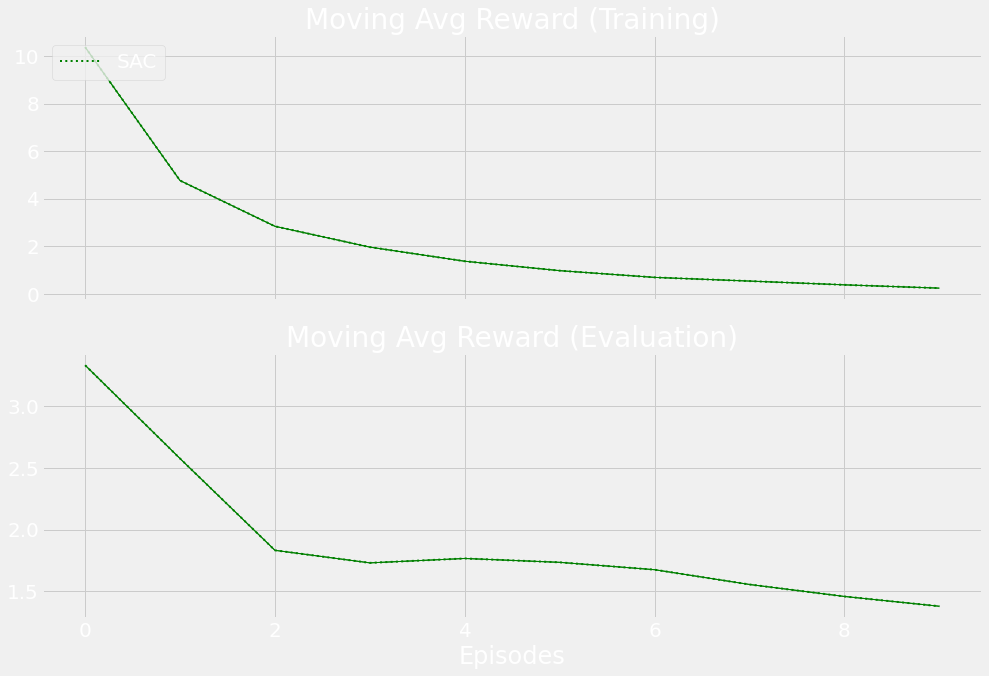

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,10), sharey=False, sharex=True)

# SAC
axs[0].plot(sac_max_r, 'g', linewidth=1)
axs[0].plot(sac_min_r, 'g', linewidth=1)
axs[0].plot(sac_mean_r, 'g:', label='SAC', linewidth=2)
axs[0].fill_between(
    sac_x, sac_min_r, sac_max_r, facecolor='g', alpha=0.3)

axs[1].plot(sac_max_s, 'g', linewidth=1)
axs[1].plot(sac_min_s, 'g', linewidth=1)
axs[1].plot(sac_mean_s, 'g:', label='SAC', linewidth=2)
axs[1].fill_between(
    sac_x, sac_min_s, sac_max_s, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

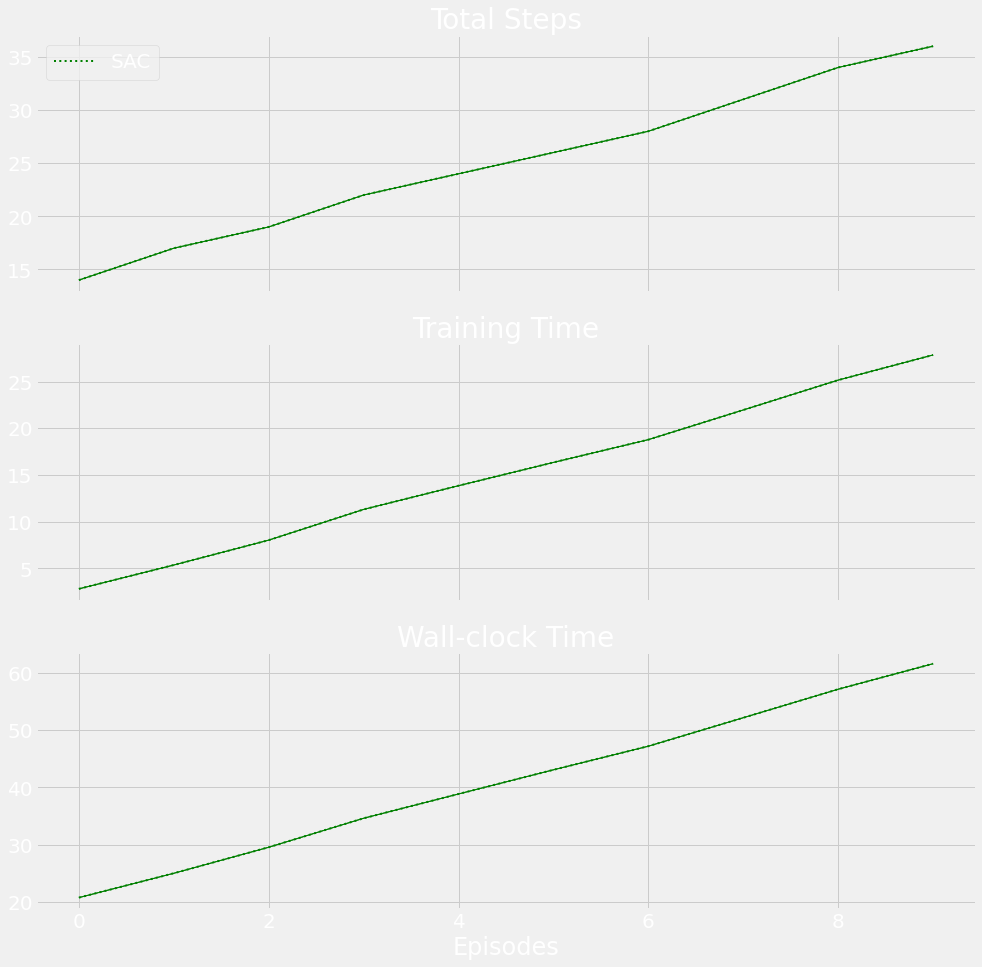

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15,15), sharey=False, sharex=True)

# SAC
axs[0].plot(sac_max_t, 'g', linewidth=1)
axs[0].plot(sac_min_t, 'g', linewidth=1)
axs[0].plot(sac_mean_t, 'g:', label='SAC', linewidth=2)
axs[0].fill_between(
    sac_x, sac_min_t, sac_max_t, facecolor='g', alpha=0.3)

axs[1].plot(sac_max_sec, 'g', linewidth=1)
axs[1].plot(sac_min_sec, 'g', linewidth=1)
axs[1].plot(sac_mean_sec, 'g:', label='SAC', linewidth=2)
axs[1].fill_between(
    sac_x, sac_min_sec, sac_max_sec, facecolor='g', alpha=0.3)

axs[2].plot(sac_max_rt, 'g', linewidth=1)
axs[2].plot(sac_min_rt, 'g', linewidth=1)
axs[2].plot(sac_mean_rt, 'g:', label='SAC', linewidth=2)
axs[2].fill_between(
    sac_x, sac_min_rt, sac_max_rt, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Total Steps')
axs[1].set_title('Training Time')
axs[2].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [ ]:
sac_root_dir = os.path.join(RESULTS_DIR, 'sac')
not os.path.exists(sac_root_dir) and os.makedirs(sac_root_dir)

np.save(os.path.join(sac_root_dir, 'x'), sac_x)

np.save(os.path.join(sac_root_dir, 'max_r'), sac_max_r)
np.save(os.path.join(sac_root_dir, 'min_r'), sac_min_r)
np.save(os.path.join(sac_root_dir, 'mean_r'), sac_mean_r)

np.save(os.path.join(sac_root_dir, 'max_s'), sac_max_s)
np.save(os.path.join(sac_root_dir, 'min_s'), sac_min_s )
np.save(os.path.join(sac_root_dir, 'mean_s'), sac_mean_s)

np.save(os.path.join(sac_root_dir, 'max_t'), sac_max_t)
np.save(os.path.join(sac_root_dir, 'min_t'), sac_min_t)
np.save(os.path.join(sac_root_dir, 'mean_t'), sac_mean_t)

np.save(os.path.join(sac_root_dir, 'max_sec'), sac_max_sec)
np.save(os.path.join(sac_root_dir, 'min_sec'), sac_min_sec)
np.save(os.path.join(sac_root_dir, 'mean_sec'), sac_mean_sec)

np.save(os.path.join(sac_root_dir, 'max_rt'), sac_max_rt)
np.save(os.path.join(sac_root_dir, 'min_rt'), sac_min_rt)
np.save(os.path.join(sac_root_dir, 'mean_rt'), sac_mean_rt)